In [20]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from optimization_tuned import (epsilon_nondominated,HypervolumeMetric, Hypervolume, ArchiveLogger, 
                                AbstractConvergenceMetric, EpsilonProgress)
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    SequentialEvaluator,
    ScalarOutcome
)
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant
#from ema_workbench.em_framework.optimization import EpsilonProgress

from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator,
                           Scenario, Policy, perform_experiments, ema_logging)
from ema_workbench.em_framework.optimization import HyperVolume


ema_logging.log_to_stderr(ema_logging.INFO)

import pickle
warnings.filterwarnings("ignore")

## Robustness Metrics

## General setup

In [2]:
dike_model, planning_steps = get_model_for_problem_formulation(6)

In [3]:
with open("data\ScenariosOpenExplo", 'rb') as file2:
    Scenarios = pickle.load(file2)

In [6]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results1 = evaluator.optimize(
        nfe=1000, searchover="levers", epsilons=[0.1] * len(dike_model.outcomes), reference=Scenarios[0]
    )

[MainProcess/INFO] pool started with 8 workers
1098it [03:20,  5.48it/s]                                                      
[MainProcess/INFO] optimization completed, found 11 solutions
[MainProcess/INFO] terminating pool


In [7]:
results=results1

## Policy setup

We probably want to use our outcomes from the MORDM here. So, our candidate policies.

In [8]:

#We create the policies from the results from the optimizer
# The results still have to be imported from the optimizer results
policies = results

#We can add manual constraints like this (reliability is an outcome)
# logical = results.reliability > 0.75
# policies = results[logical]

#Just keep in the policies, and get rid of the outcomes
policies = policies.drop([o.name for o in dike_model.outcomes], axis=1)

#Create Policy objects
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [12]:
# Run 1000 scenarios for each of the policy options

n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1000 scenarios * 11 policies * 1 model(s) = 11000 experiments
100%|████████████████████████████████████| 11000/11000 [29:29<00:00,  6.22it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


## Signal to Noise ratio

In [14]:
results

(       A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
 0                           80  334.354442       1.0   0.748038  195.836810   
 1                           75  103.990534       1.0   0.498166  121.185162   
 2                          118  173.602092       1.5   0.471211  304.870684   
 3                          129  108.890114       1.5   0.565304  277.991593   
 4                           66  205.648956      10.0   0.790061   53.485279   
 ...                        ...         ...       ...        ...         ...   
 10995                      119   59.745350       1.5   0.803817  272.541813   
 10996                       28  226.223635      10.0   0.453948   67.137549   
 10997                       23   89.837004       1.5   0.923451  230.396427   
 10998                       24  123.639713      10.0   0.687416  266.961789   
 10999                      107  102.631264       1.0   0.093714  332.142264   
 
       A.2_Brate  A.2_pfail    A.3_Bma

In [13]:
#For an outcome indicator to be minimized, a lower mean and a lower standard deviation is preferred.
#We want all our signal to noise ratios to be minimized

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [15]:
experiments, outcomes = results

In [21]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.5_Expected Number of Deaths,A.5_Expected Annual Damage,Expected Evacuation Costs,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
0,4.412891e-09,4.162681e+11,3.723699e+07,2.661148e+17,4.527584e+12,0.001761
1,8.686711e-06,9.316942e+13,3.383827e+07,9.595953e+17,2.873213e+12,0.057091
10,6.316913e-07,3.758747e+13,1.598995e+08,6.303575e+17,6.277751e+12,0.010354
2,2.423922e-05,2.861237e+13,0.000000e+00,7.939249e+16,5.230842e+01,0.108396
3,1.048795e-06,5.120633e+13,7.987692e+08,5.546997e+17,1.245478e+13,0.033651
4,9.474063e-05,1.222327e+14,0.000000e+00,1.544896e+17,2.634919e+01,0.073324
5,6.765464e-05,8.075900e+13,0.000000e+00,2.474882e+17,8.055999e+01,0.192032
6,4.201328e-06,2.312285e+14,7.735287e+07,5.622277e+16,6.584117e+12,0.002937
7,6.634715e-06,7.070267e+13,3.691724e+06,1.465626e+16,1.548068e+12,0.001433
8,5.964759e-04,7.002088e+14,0.000000e+00,6.650472e+15,4.963378e+01,0.005788


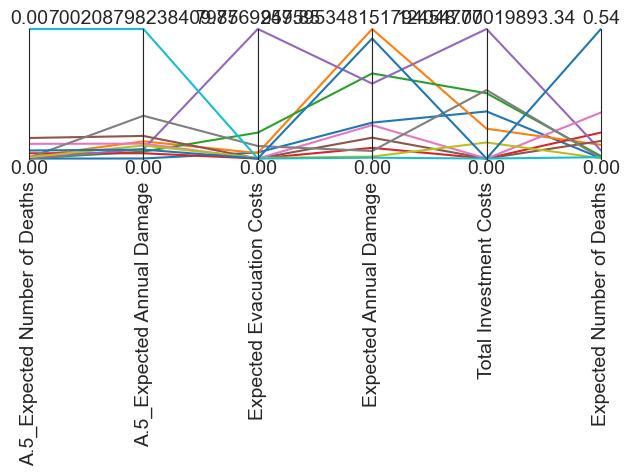

In [25]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.5_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'Expected Evacuation Costs',
               'Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

## Regret

In [26]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [27]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

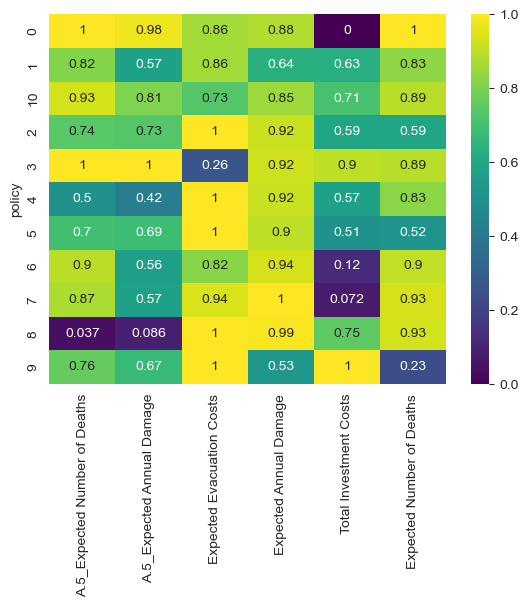

In [28]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret / max_regret.max(), cmap='viridis', annot=True)
plt.show()


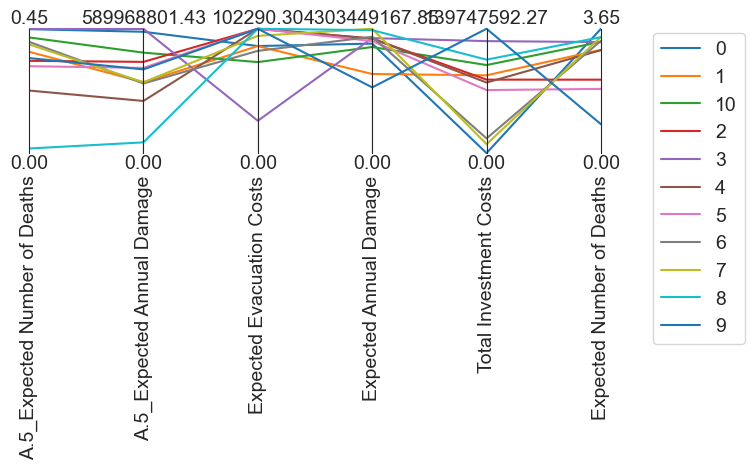

In [36]:
data = max_regret

colors = sns.color_palette(n_colors=len(data))


# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['A.5_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'Expected Evacuation Costs',
               'Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

In [37]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

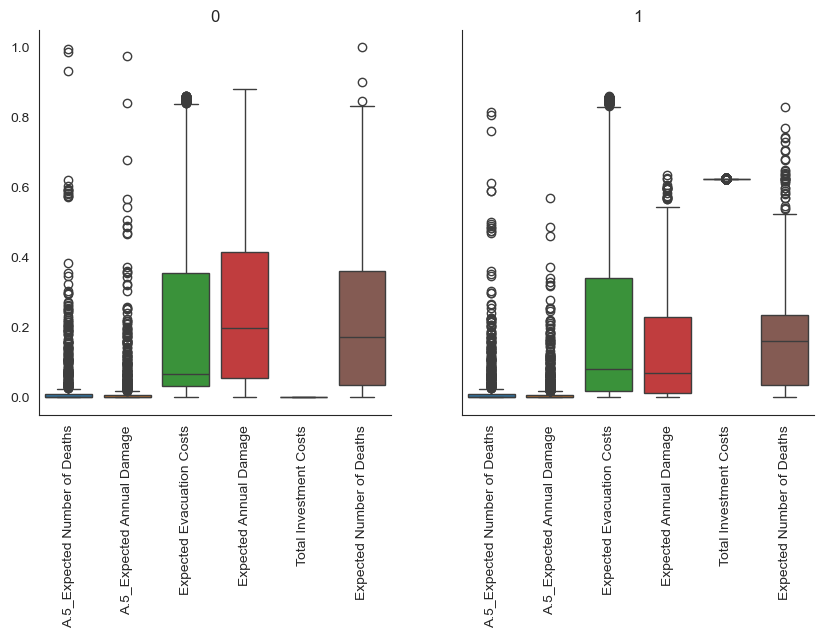

In [39]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=2, figsize=(10,5), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 


# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
    
    # Rotate x-axis labels vertically
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
plt.show()